In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07
mean,-7.554751e-17,2.325436e-16,-1.969976e-14,-2.478637e-14,-1.175991e-15,-7.503728e-15,4.034983e-14,-3.315205e-15,-1.910605e-15,4.421118e-16,-5.968948e-16,2.790048e-16,2.490396e-15,1.438155e-14,1.090860e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.249306e+02,-3.814446e+02,-7.457400e+01,-2.143341e+00,-1.921246e+00,-1.297033e+00,-1.710608e+02,-1.277790e+00,-8.474415e+01,-2.678420e+01,-5.509811e+01,-2.109354e+02,-1.799047e+00,-3.488317e+00,-3.060594e+00
25%,-3.258431e-02,-2.497779e-01,-2.199693e-01,-5.673091e-01,-7.880002e-01,-7.826355e-01,1.095864e-04,-7.187233e-01,-5.207354e-01,-3.142720e-01,-1.510736e-01,-1.056034e-01,-2.791258e-01,-1.170805e-01,-7.257788e-01
50%,-1.714946e-02,-1.156905e-01,-2.199693e-01,-5.673091e-01,4.251098e-02,-1.509808e-01,1.095864e-04,-2.630268e-01,-2.760170e-01,-2.158643e-01,-9.455876e-02,-4.192553e-02,-2.264989e-01,-8.693051e-02,-1.606022e-01
75%,5.464286e-03,6.980049e-02,1.017680e-01,3.190794e-01,8.328257e-01,5.075416e-01,1.095864e-04,4.315107e-01,2.244570e-01,6.491163e-02,-1.128275e-02,3.915007e-02,-6.719322e-02,-8.693051e-02,5.922162e-01
max,2.249695e+02,3.585519e+02,5.236406e+01,5.679170e+00,1.572247e+00,1.505446e+01,1.710611e+02,2.417821e+01,2.851771e+02,1.440235e+02,6.117973e+01,2.106058e+02,2.036316e+01,1.787184e+01,8.109160e+00


In [4]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

n = 10_000
df_test = pd.read_pickle(test)
target = df_test['target']

df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]
df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06,2.209628e+06
mean,-5.956583e-17,6.122434e-17,-3.135110e-15,-8.355476e-15,2.383218e-16,1.525072e-15,2.131544e-14,-1.902655e-15,-4.907369e-16,-1.569095e-18,8.635701e-17,3.133119e-16,-1.612169e-16,-8.538924e-15,-2.840101e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.386475e+01,-6.598887e+00,-1.894410e+01,-2.064727e+00,-1.685797e+00,-1.271646e+00,-2.609861e+01,-1.227295e+00,-2.206550e+00,-4.283260e+00,-1.540094e+01,-7.623715e+00,-1.819762e+00,-3.979516e+00,-3.129206e+00
25%,-4.041698e-01,-5.671836e-01,-2.931734e-01,-5.315990e-01,-9.629006e-01,-7.970153e-01,4.211448e-02,-7.368617e-01,-6.529241e-01,-4.752486e-01,-3.493425e-01,-5.474067e-01,-2.691910e-01,-1.083496e-01,-7.258671e-01
50%,-2.000343e-01,-2.617571e-01,-2.931734e-01,-5.315990e-01,-1.392759e-01,-1.543580e-01,4.211448e-02,-2.880362e-01,-3.912937e-01,-3.346264e-01,-1.949291e-01,-2.497517e-01,-2.121132e-01,-1.083496e-01,-1.347984e-01
75%,9.636549e-02,2.113943e-01,-2.571284e-02,1.527294e-01,9.358571e-01,5.055925e-01,4.211448e-02,4.403853e-01,2.807673e-01,8.103228e-02,4.739077e-02,2.637120e-01,-9.611890e-02,-1.083496e-01,5.852202e-01
max,1.374234e+01,1.091405e+01,2.923029e+01,5.544833e+00,1.680935e+00,1.530832e+01,1.312432e+01,2.527071e+01,6.818796e+00,1.865422e+01,1.445261e+01,1.283230e+01,2.085188e+01,2.033078e+01,6.972556e+00


## Model 1 - AE trained on inputs that give outputs

In [5]:
path = glob.glob("/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-13/*")[0]

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.0025)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [6]:
data_good = torch.from_numpy(df_test_good.values).float()
outputs_good = encoder.forward(data_good).detach().numpy()

<IPython.core.display.Javascript object>


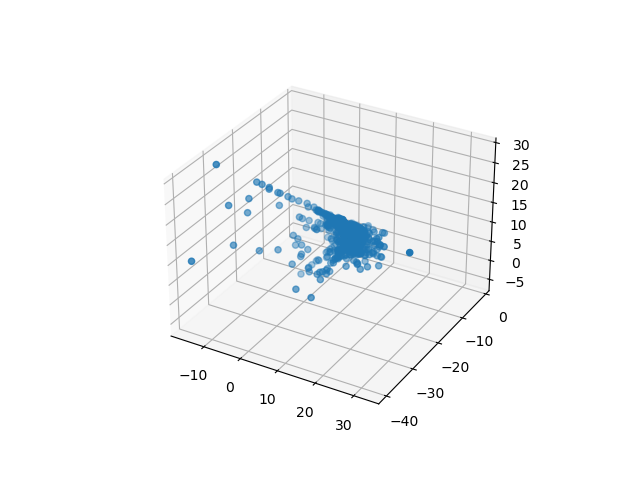

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
fig.show()

<IPython.core.display.Javascript object>


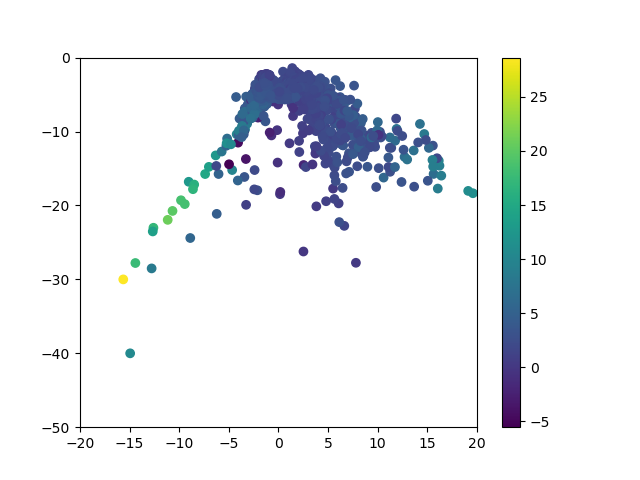

In [8]:
plt.figure()

sc = plt.scatter(outputs_good[:n,0], outputs_good[:n,1], c = outputs_good[:n,2])
plt.xlim(-20,20)
plt.ylim(-50,0)
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [9]:
AE_output = model.forward(data_good).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [10]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


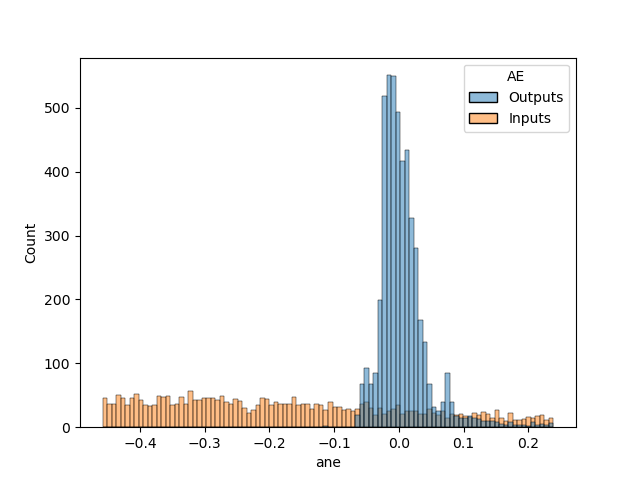

<IPython.core.display.Javascript object>


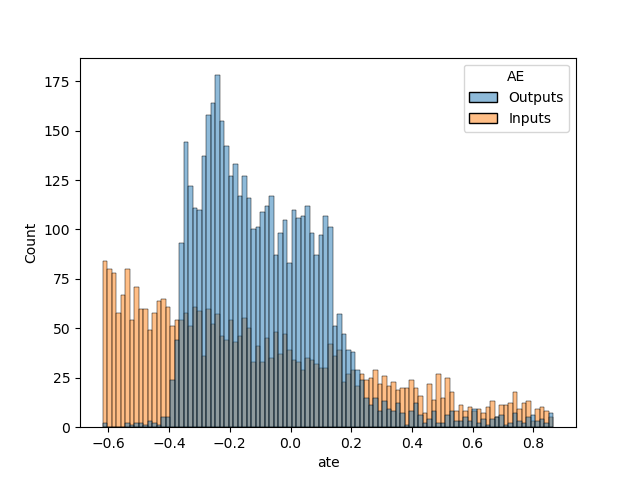

<IPython.core.display.Javascript object>


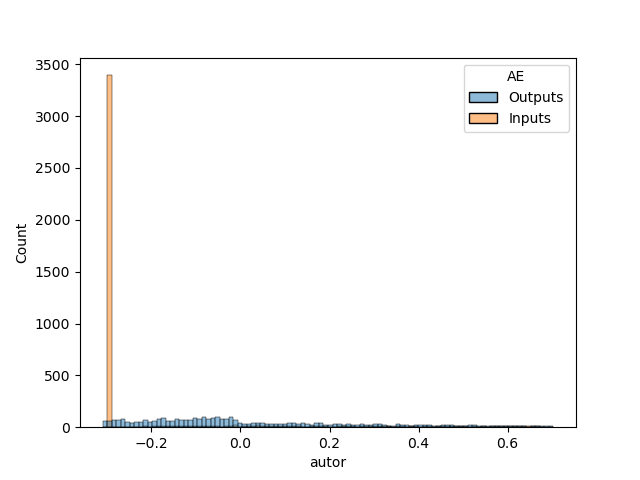

<IPython.core.display.Javascript object>


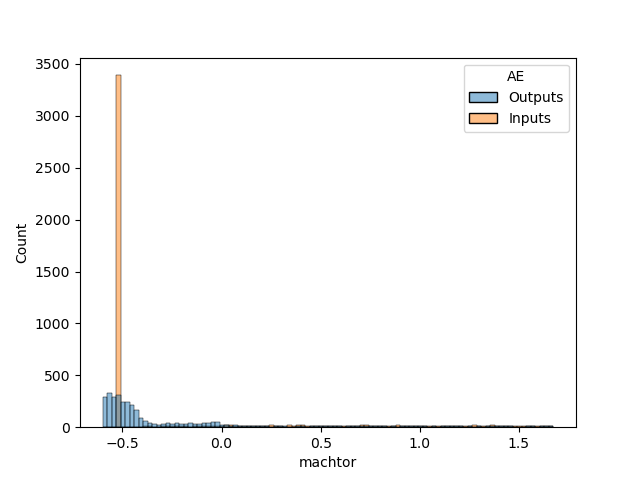

<IPython.core.display.Javascript object>


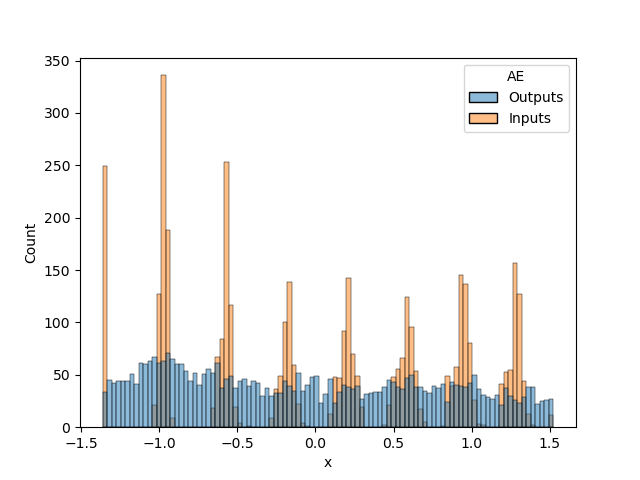

<IPython.core.display.Javascript object>


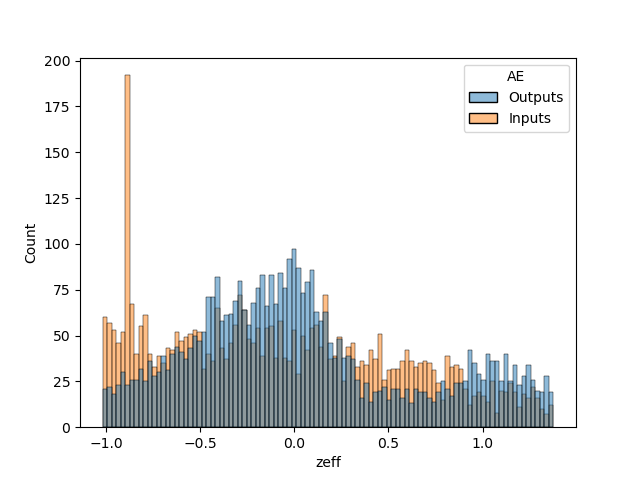

<IPython.core.display.Javascript object>


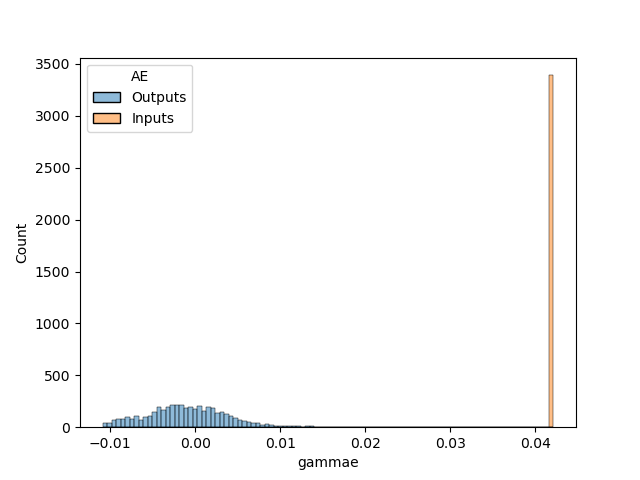

<IPython.core.display.Javascript object>


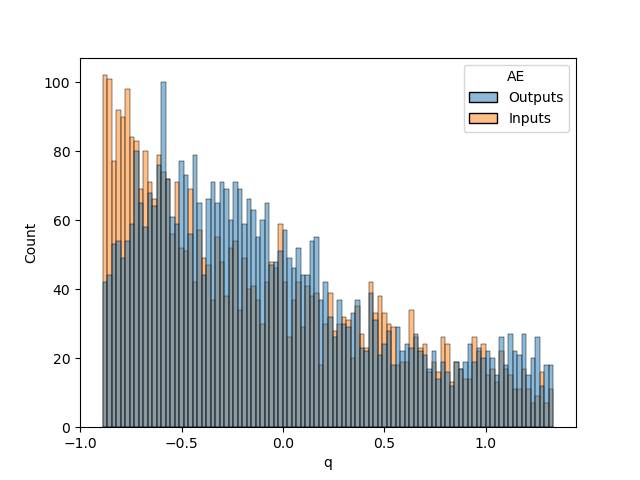

<IPython.core.display.Javascript object>


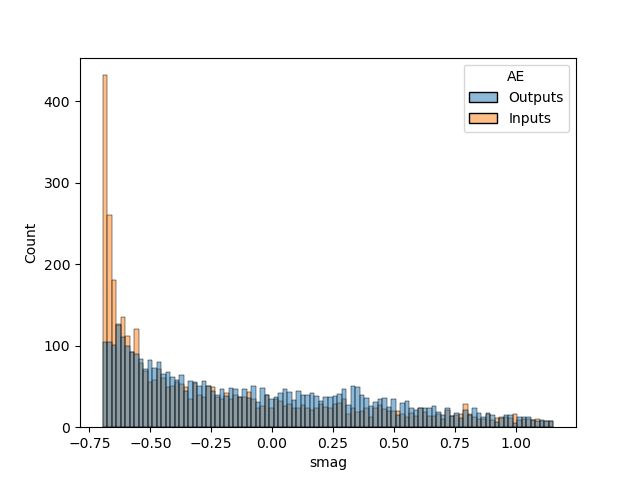

<IPython.core.display.Javascript object>


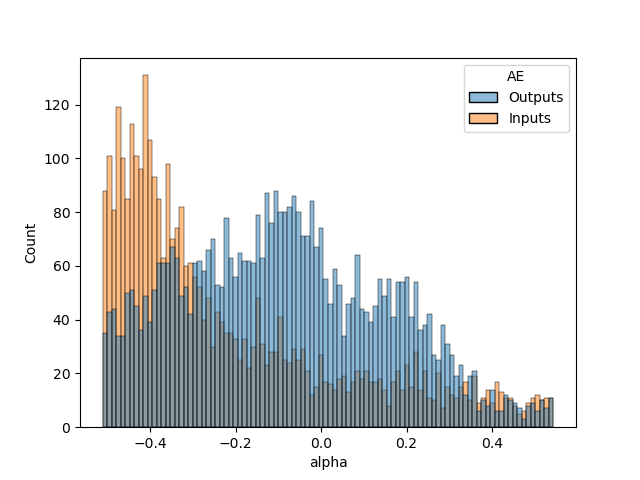

<IPython.core.display.Javascript object>


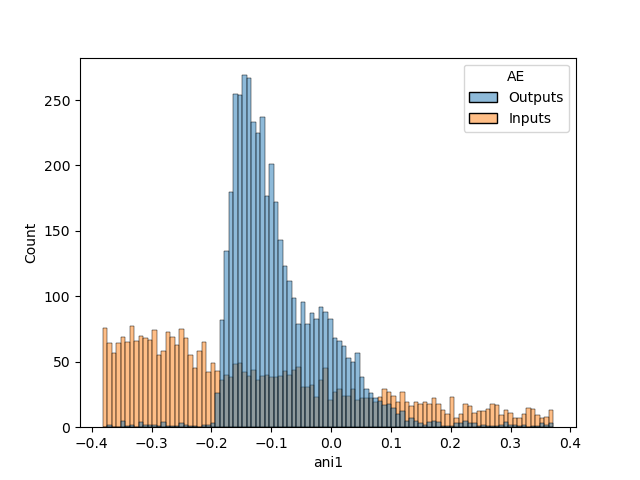

<IPython.core.display.Javascript object>


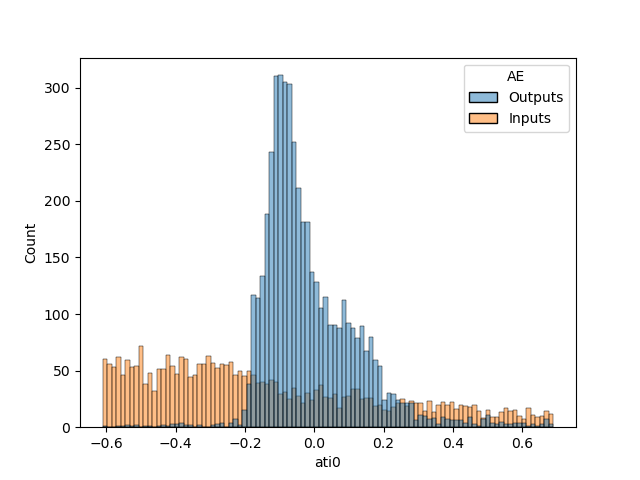

<IPython.core.display.Javascript object>


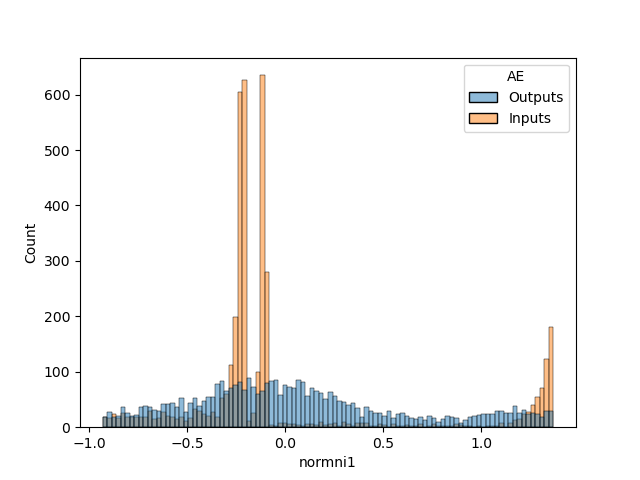

<IPython.core.display.Javascript object>


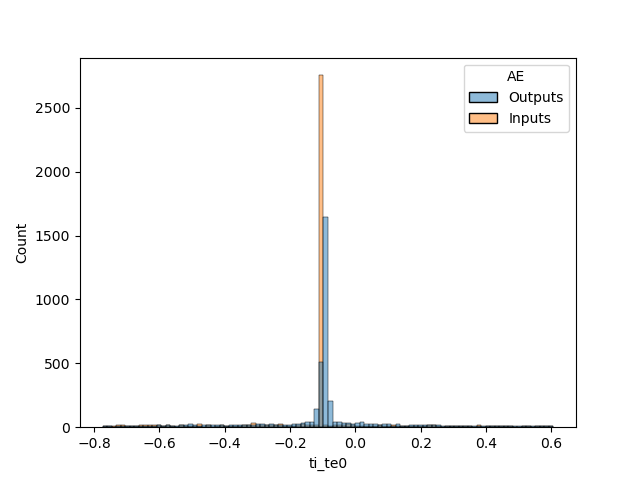

<IPython.core.display.Javascript object>


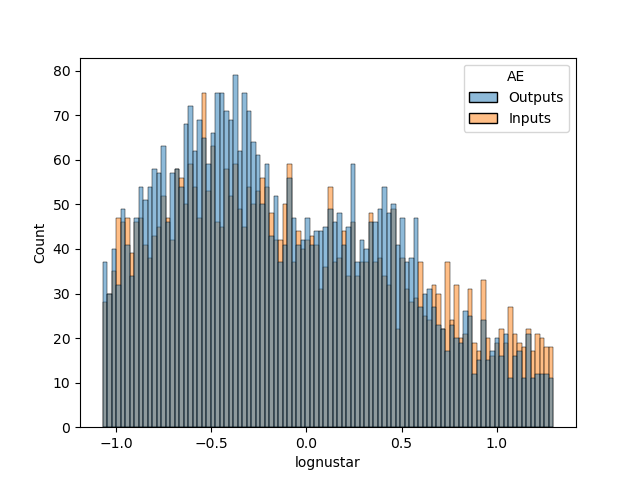

In [11]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on all inputs

In [12]:
data_bad = torch.from_numpy(df_test_bad.values).float()
outputs_bad = encoder.forward(data_bad).detach().numpy()

<IPython.core.display.Javascript object>


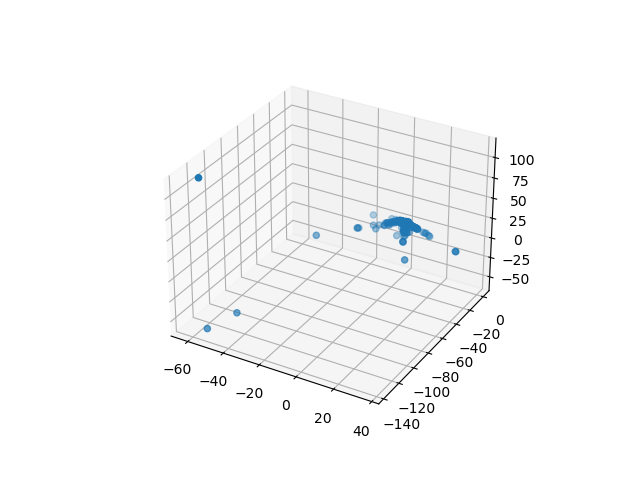

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_bad[:n,0], outputs_bad[:n,1],outputs_bad[:n,2])
fig.show()

<IPython.core.display.Javascript object>


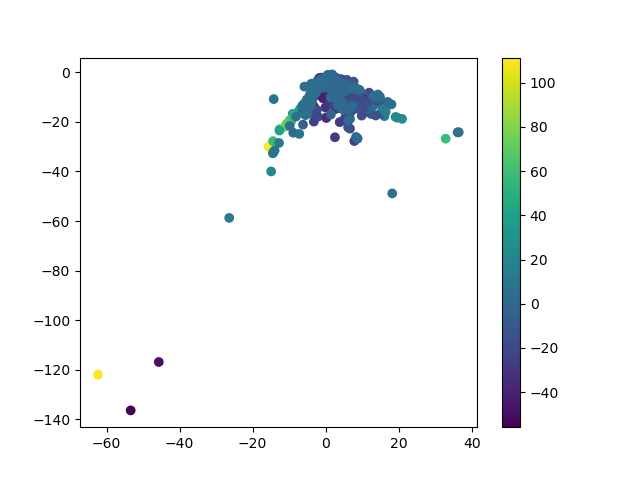

In [14]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_good[:n,0], outputs_good[:n,1], c = outputs_good[:n,2])
plt.scatter(outputs_bad[:n,0], outputs_bad[:n,1], c = outputs_bad[:n,2])
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


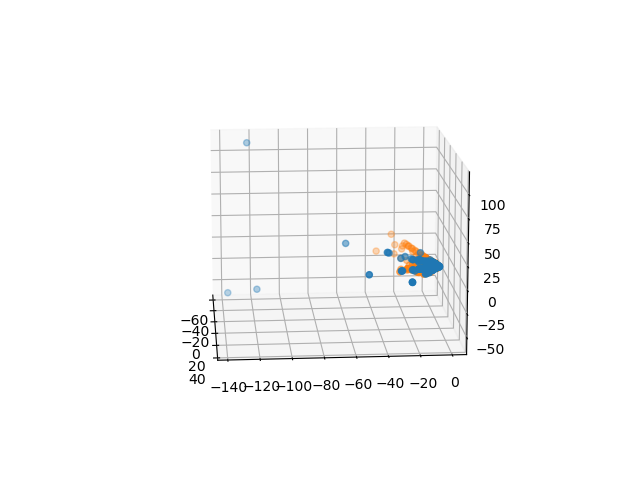

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_bad[:n,0], outputs_bad[:n,1],outputs_bad[:n,2])
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
fig.show()



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [21]:
df_1 = pd.DataFrame(data = outputs_good)
df_1['target'] = 1

df_2 = pd.DataFrame(data = outputs_bad)
df_2['target'] = 0

df = pd.concat([df_1, df_2])

class_train, class_test = train_test_split(df)
class_train

,0,1,2,target
1939196,0.890775,-4.695124,2.214744,1
1982757,0.117065,-5.145235,2.679790,1
523306,-1.101742,-4.558691,3.429834,1
1955408,-0.190405,-5.159791,2.887208,1
996334,-1.574928,-4.646876,2.958039,1
...,...,...,...,...
1884699,1.362578,-4.980683,2.663577,1
1230891,-1.727871,-5.316798,3.523068,1
2025364,1.726506,-4.364266,2.166058,1
381423,1.651356,-3.991392,2.065999,0


In [ ]:
#clf = LogisticRegression(C = 10, class_weight = 'balanced')
clf = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced')
clf.fit(class_train[[0, 1, 2]], class_train['target'])

In [24]:
preds = clf.predict(class_test[[0,1,2]])
tn, fp, fn, tp = confusion_matrix(class_test['target'], preds).ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

In [25]:
print(tpr, tnr)

0.5685888900146184 0.4149447449192971


In [26]:
confusion_matrix(class_test['target'], preds)

array([[117075, 165071],
       [238453, 314275]])